In [1]:
### Imports, some helper functions
import numpy as np
import xarray as xr
import glob
import os
import hashlib
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import colormaps
from matplotlib import cm
import seaborn as sns
import pprint
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pprint import pp

# let's test for now...
from xarray_cacher import *

In [2]:
### Data loading
# Corrected lat-lon grid will be handled separately 
model_grid = xr.open_mfdataset("/data/ycheng46/NNA/data/alaska_climate_region.nc")
static_lat2d = model_grid.lat.values
static_lon2d = model_grid.lon.values % 360

soil_liquid_paths = ["/data/shared_data/NNA/NNA.4km.hERA5.1989.003/soilliq_m/*.nc",
                     "/data/shared_data/NNA/NNA.4km.fPGWh.2033.004/soilliq_m/*.nc",
                     "/data/shared_data/NNA/NNA.4km.fPGWm.2033.005/soilliq_m/*.nc" ]

soil_liquid_P, soil_liquid_H, soil_liquid_M = unpacker(soil_liquid_paths, "SOILLIQ")

In [3]:
### Data cleanup
## Constants
seconds_per_year = 365.25 * 86400
seconds_per_season = 90.25 * 86400

## Helpers for our cache functions
def compute_annual_generic(ds):
    return ds.groupby("time.year").mean(dim="time", skipna=True, keep_attrs=True)

def compute_annual_runoff(ds):
    return ds.groupby("time.year").mean(dim="time", skipna=True, keep_attrs=True)

def compute_geo_average_future(ds):
    return ds.mean(dim=("lat", "lon"), skipna=True, keep_attrs=True).sel(year=slice(2034, 2064))

def compute_geo_average_historic(ds):
    return ds.mean(dim=("lat", "lon"), skipna=True, keep_attrs=True).sel(year=slice(1990, 2020))

def compute_layer_average_future(ds):
    return ds.mean(dim=("lat", "lon"), skipna=True, keep_attrs=True).sum(dim="levsoi").sel(year=slice(2034, 2064))

def compute_layer_average_historic(ds):
    return ds.mean(dim=("lat", "lon"), skipna=True, keep_attrs=True).sum(dim="levsoi").sel(year=slice(1990, 2020))

## Soil liquid
# these don't change anything, but I'm leaving it here
# so it makes it easy to mass edit if needed later.
total_soil_liquid_P = soil_liquid_P
total_soil_liquid_H = soil_liquid_H
total_soil_liquid_M = soil_liquid_M

annual_soil_liquid_P = cache_xarray(compute_annual_generic, total_soil_liquid_P, name_hint="annual_soil_liquid_P")
annual_soil_liquid_H = cache_xarray(compute_annual_generic, total_soil_liquid_H, name_hint="annual_soil_liquid_H")
annual_soil_liquid_M = cache_xarray(compute_annual_generic, total_soil_liquid_M, name_hint="annual_soil_liquid_M")

# needed for the graphs later
clean_annual_soil_liquid_P = cache_xarray(compute_geo_average_historic, annual_soil_liquid_P, name_hint="clean_annual_soil_liquid_P")
clean_annual_soil_liquid_H = cache_xarray(compute_geo_average_future, annual_soil_liquid_H, name_hint="clean_annual_soil_liquid_H")
clean_annual_soil_liquid_M = cache_xarray(compute_geo_average_future, annual_soil_liquid_M, name_hint="clean_annual_soil_liquid_M")

# needed for the graphs later
annual_soil_liquid_numpy_P = cache_xarray(compute_layer_average_historic, annual_soil_liquid_P, name_hint="annual_soil_liquid_numpy_P")
annual_soil_liquid_numpy_H = cache_xarray(compute_layer_average_future, annual_soil_liquid_H, name_hint="annual_soil_liquid_numpy_H")
annual_soil_liquid_numpy_M = cache_xarray(compute_layer_average_future, annual_soil_liquid_M, name_hint="annual_soil_liquid_numpy_M")

In [4]:
### Stacker helper function, for plotting by depth
def stacker(dataset, var_name, graph_name, colorscheme):
    """Takes a groundwater dataset in, returns a stacked bar chart."""
    n_bins = 5
    layers_per_bin = 20 // n_bins # so 4, but leaving it dynamic in case n changes
    data = dataset.values
    binned_data = np.stack([
        data[:, i*layers_per_bin : (i+1)*layers_per_bin].sum(axis=1)
        for i in range(n_bins)
    ], axis=1)
    
    soil_stack = np.cumsum(binned_data, axis=1)
    years = dataset.year.values
    n_layers = soil_stack.shape[1]

    depths = [round(x, 2) for x in dataset.levsoi.values.tolist()]
    labels = [f"{depths[i*layers_per_bin]}–{depths[(i+1)*layers_per_bin - 1]} m" for i in range(n_bins)]

    cmap = cm.get_cmap(colorscheme, n_layers) # use tab20 if you're not binning
    colors = [cmap(i) for i in range(n_layers)]

    plt.rc('font', size=15)
    fig, ax = plt.subplots(figsize=(10, 5), dpi=600, constrained_layout=True)
    for i in range(n_layers):
        bottom = soil_stack[:, i - 1] if i > 0 else np.zeros_like(soil_stack[:, i])
        top = soil_stack[:, i]
        ax.fill_between(years, bottom, top, color=colors[i], alpha=0.7, label=labels[i])

    ax.set_xlabel("Year")
    ax.set_ylabel(f"Soil {var_name} (kg/m^2)")
    ax.set_title(f"Total Annual Soil {var_name} by Layer ({graph_name})")

    ax.legend(
        loc="upper left",
        bbox_to_anchor=(1.01, 1.0),
        borderaxespad=0,
        title="Depth Layer",
        ncol=1
    )
    fig.tight_layout(rect=[0, 0, 0.85, 1])

    ax.grid(True)
    ## saving this work to disk
    os.makedirs("soil_liquid", exist_ok=True)
    plt.savefig(f"soil_liquid/{graph_name}-{var_name}.png")

/tmp/ipykernel_1995650/3734263677.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colorscheme, n_layers) # use tab20 if you're not binning
/tmp/ipykernel_1995650/3734263677.py:40: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, 0.85, 1])


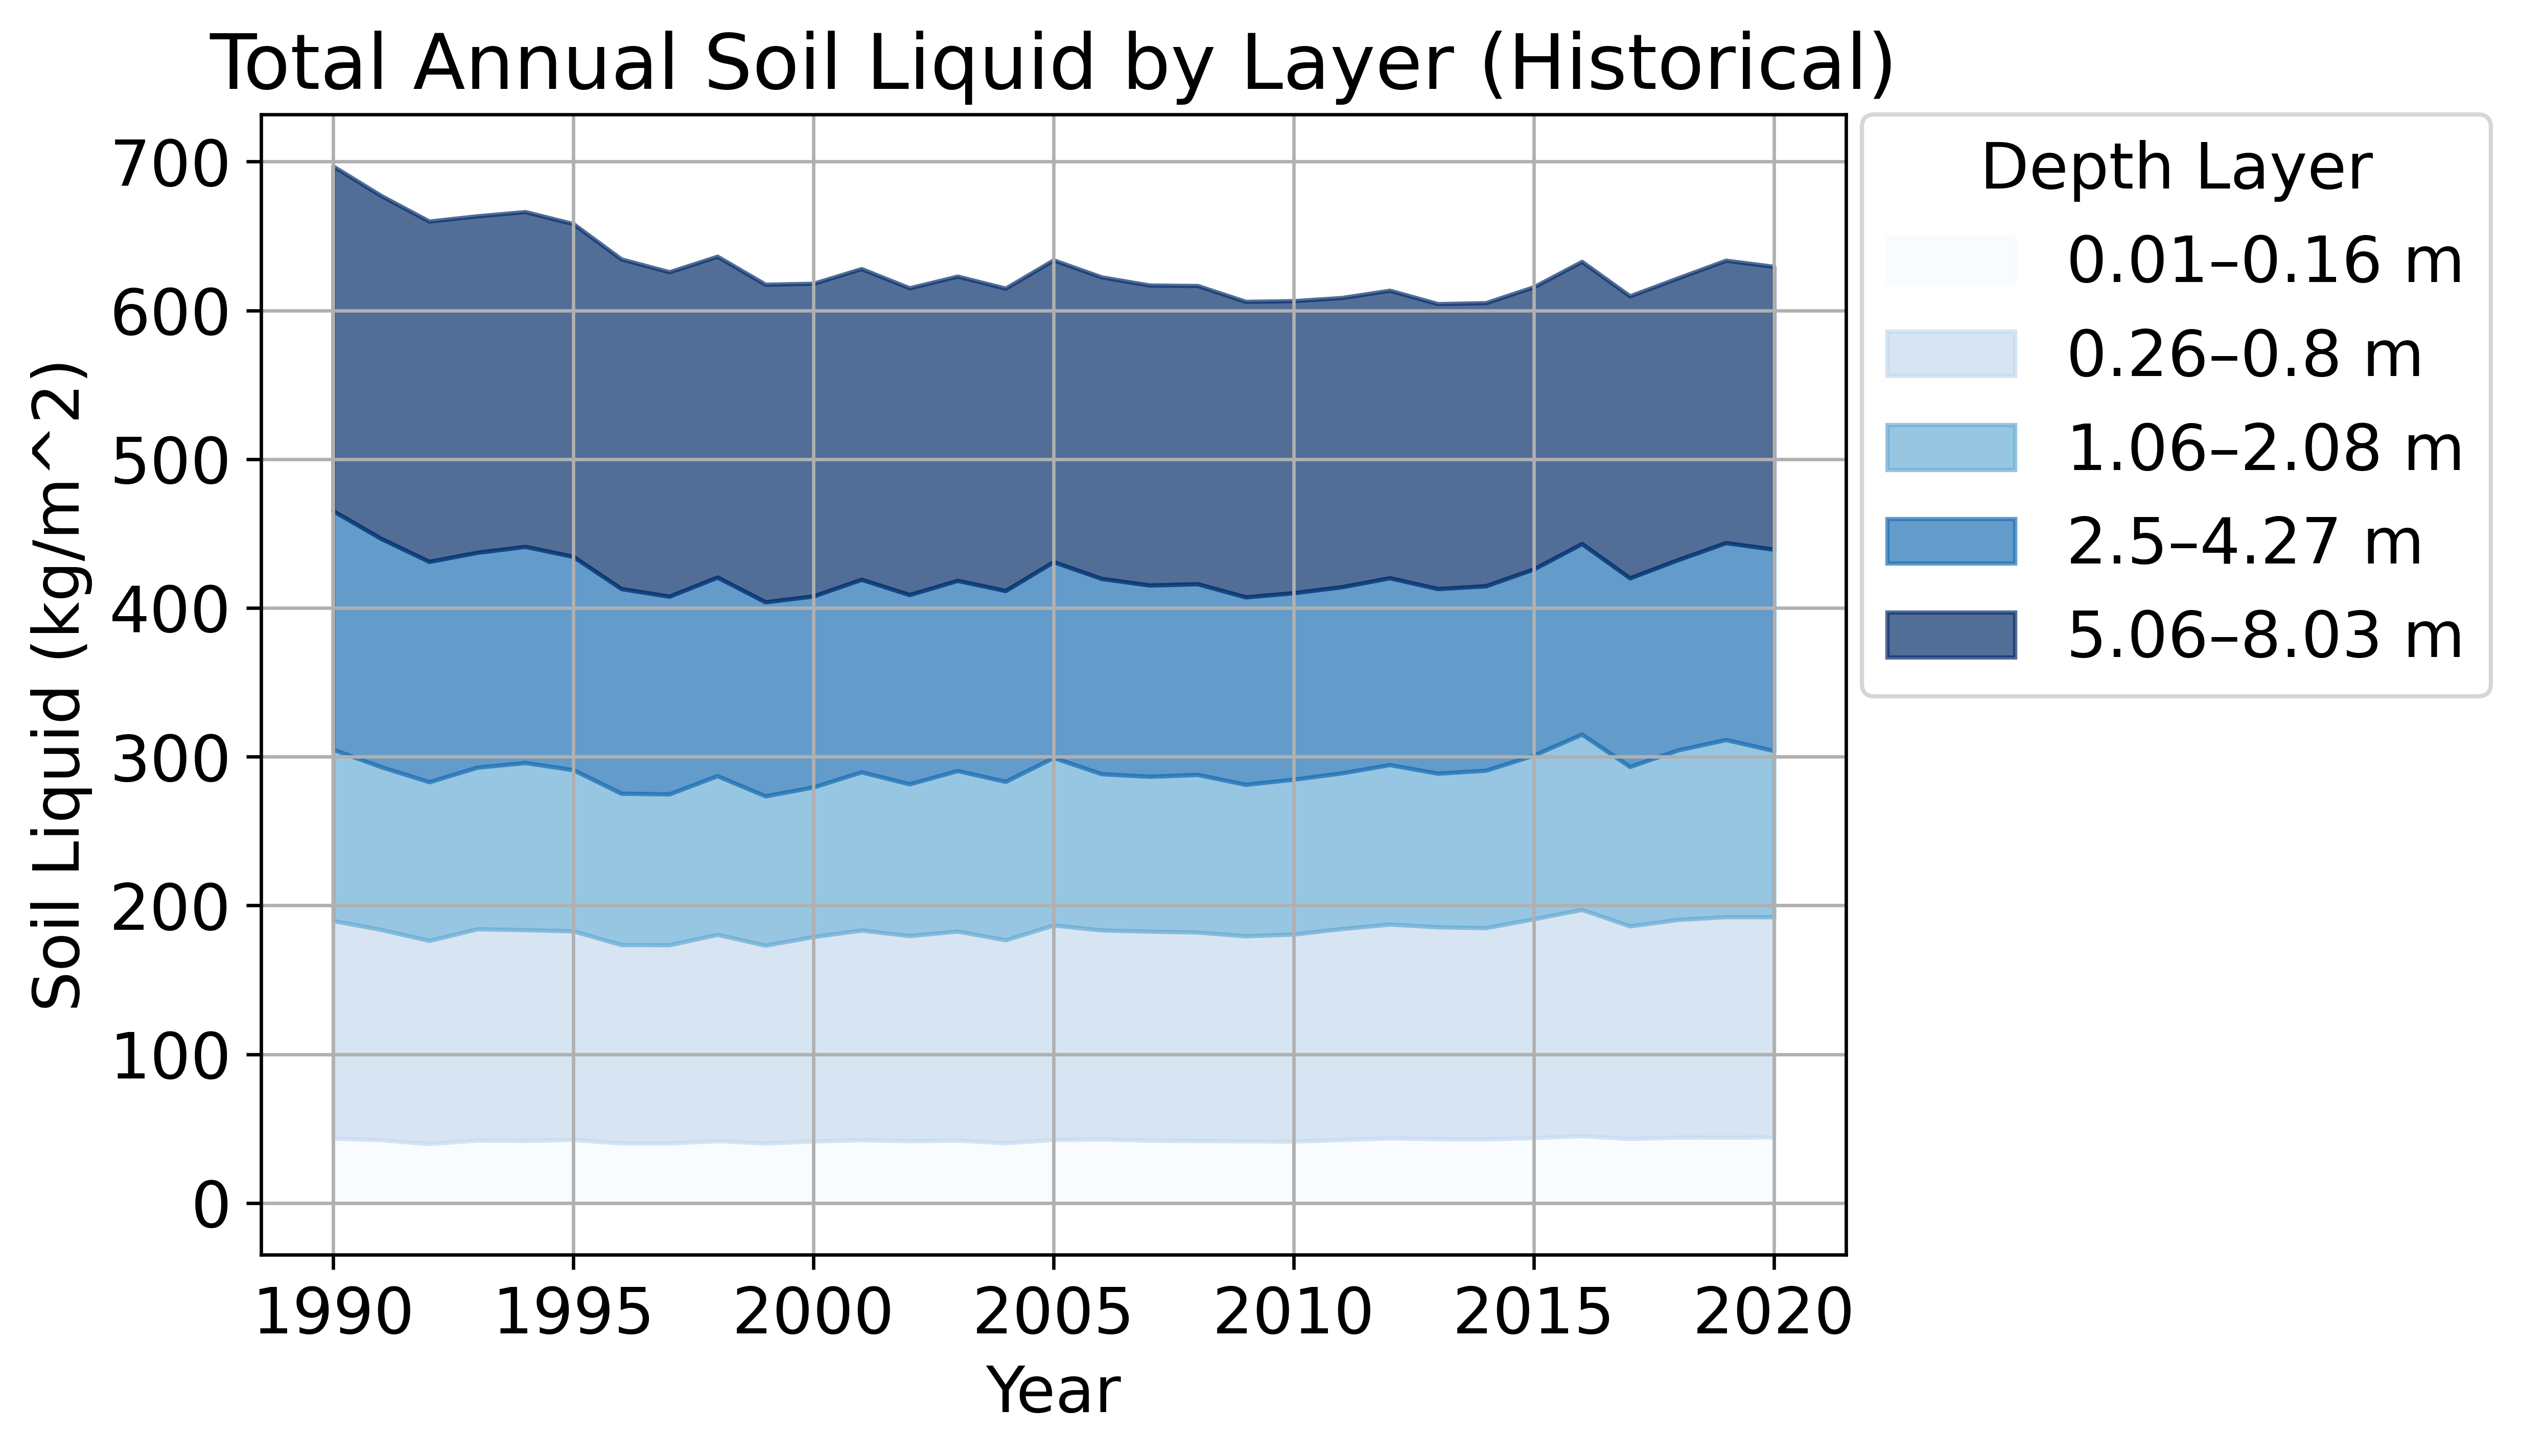

In [5]:
### Data visualization: soil liquid stacked line graphs
# This is split up so that a fail on one of them doesn't break the others
stacker(clean_annual_soil_liquid_P, "Liquid", "Historical", "Blues")

/tmp/ipykernel_1995650/3734263677.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colorscheme, n_layers) # use tab20 if you're not binning
/tmp/ipykernel_1995650/3734263677.py:40: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, 0.85, 1])


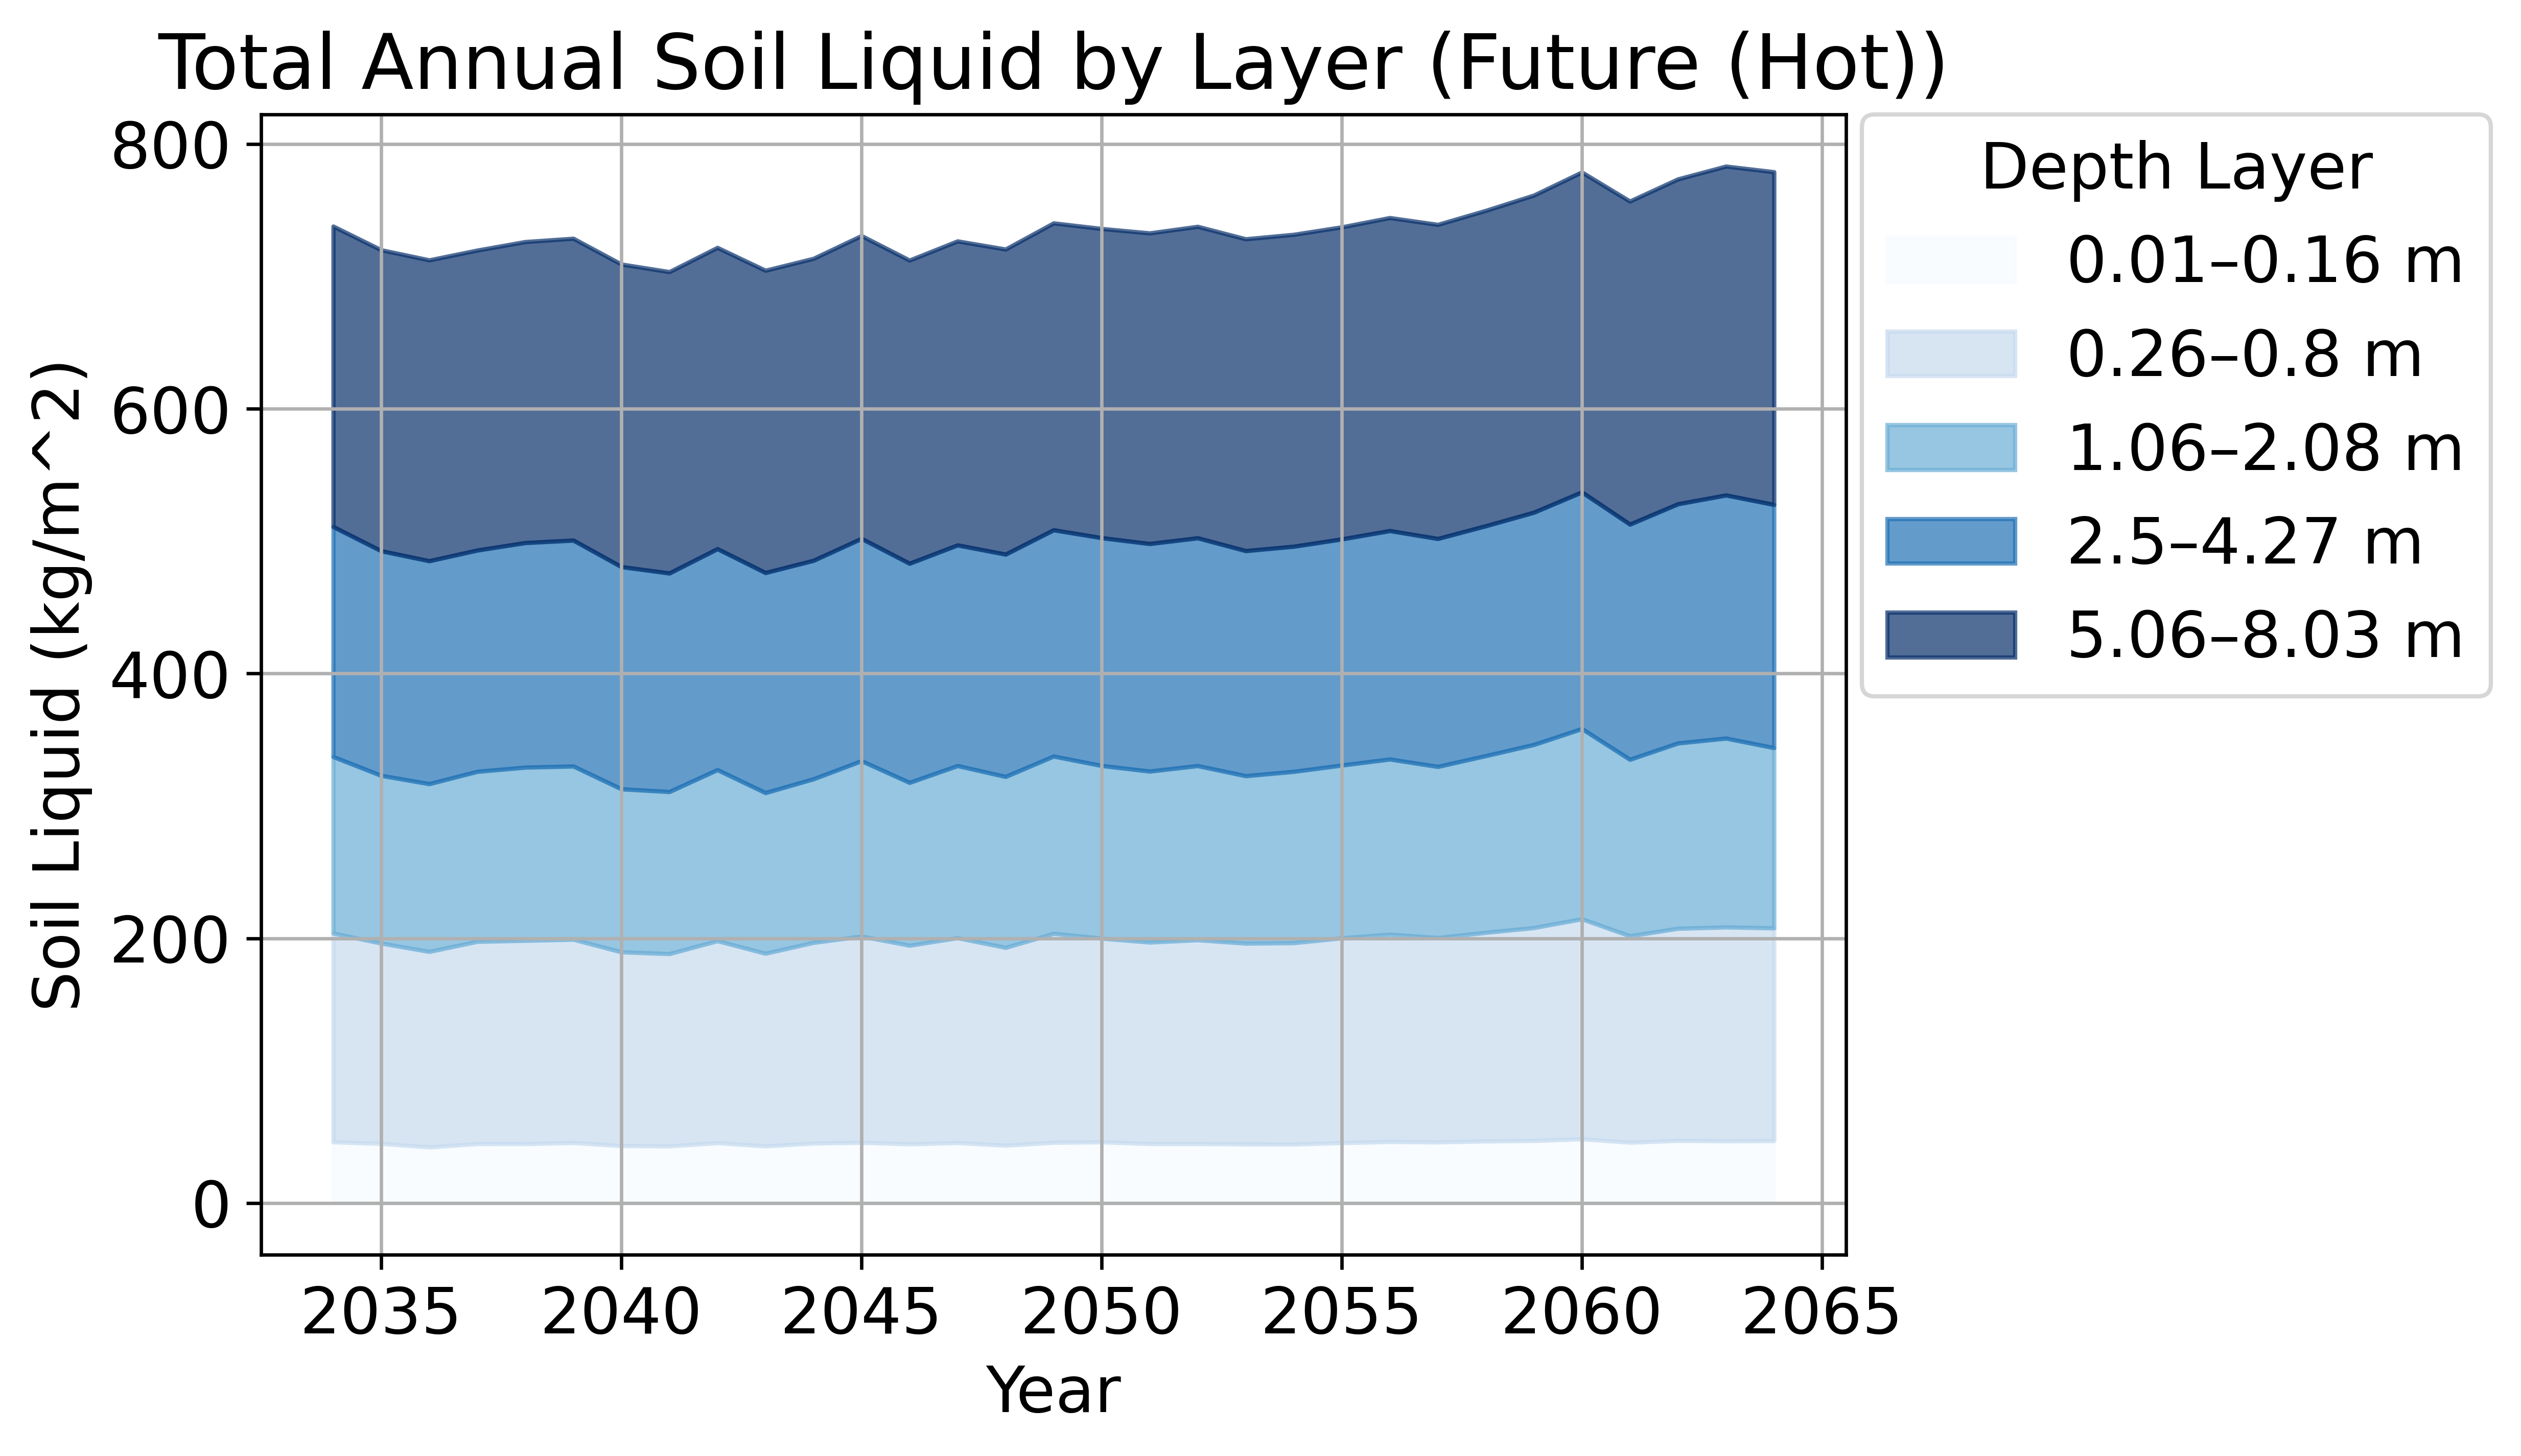

In [6]:
stacker(clean_annual_soil_liquid_H, "Liquid", "Future (Hot)", "Blues")

/tmp/ipykernel_1995650/3734263677.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colorscheme, n_layers) # use tab20 if you're not binning
/tmp/ipykernel_1995650/3734263677.py:40: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, 0.85, 1])


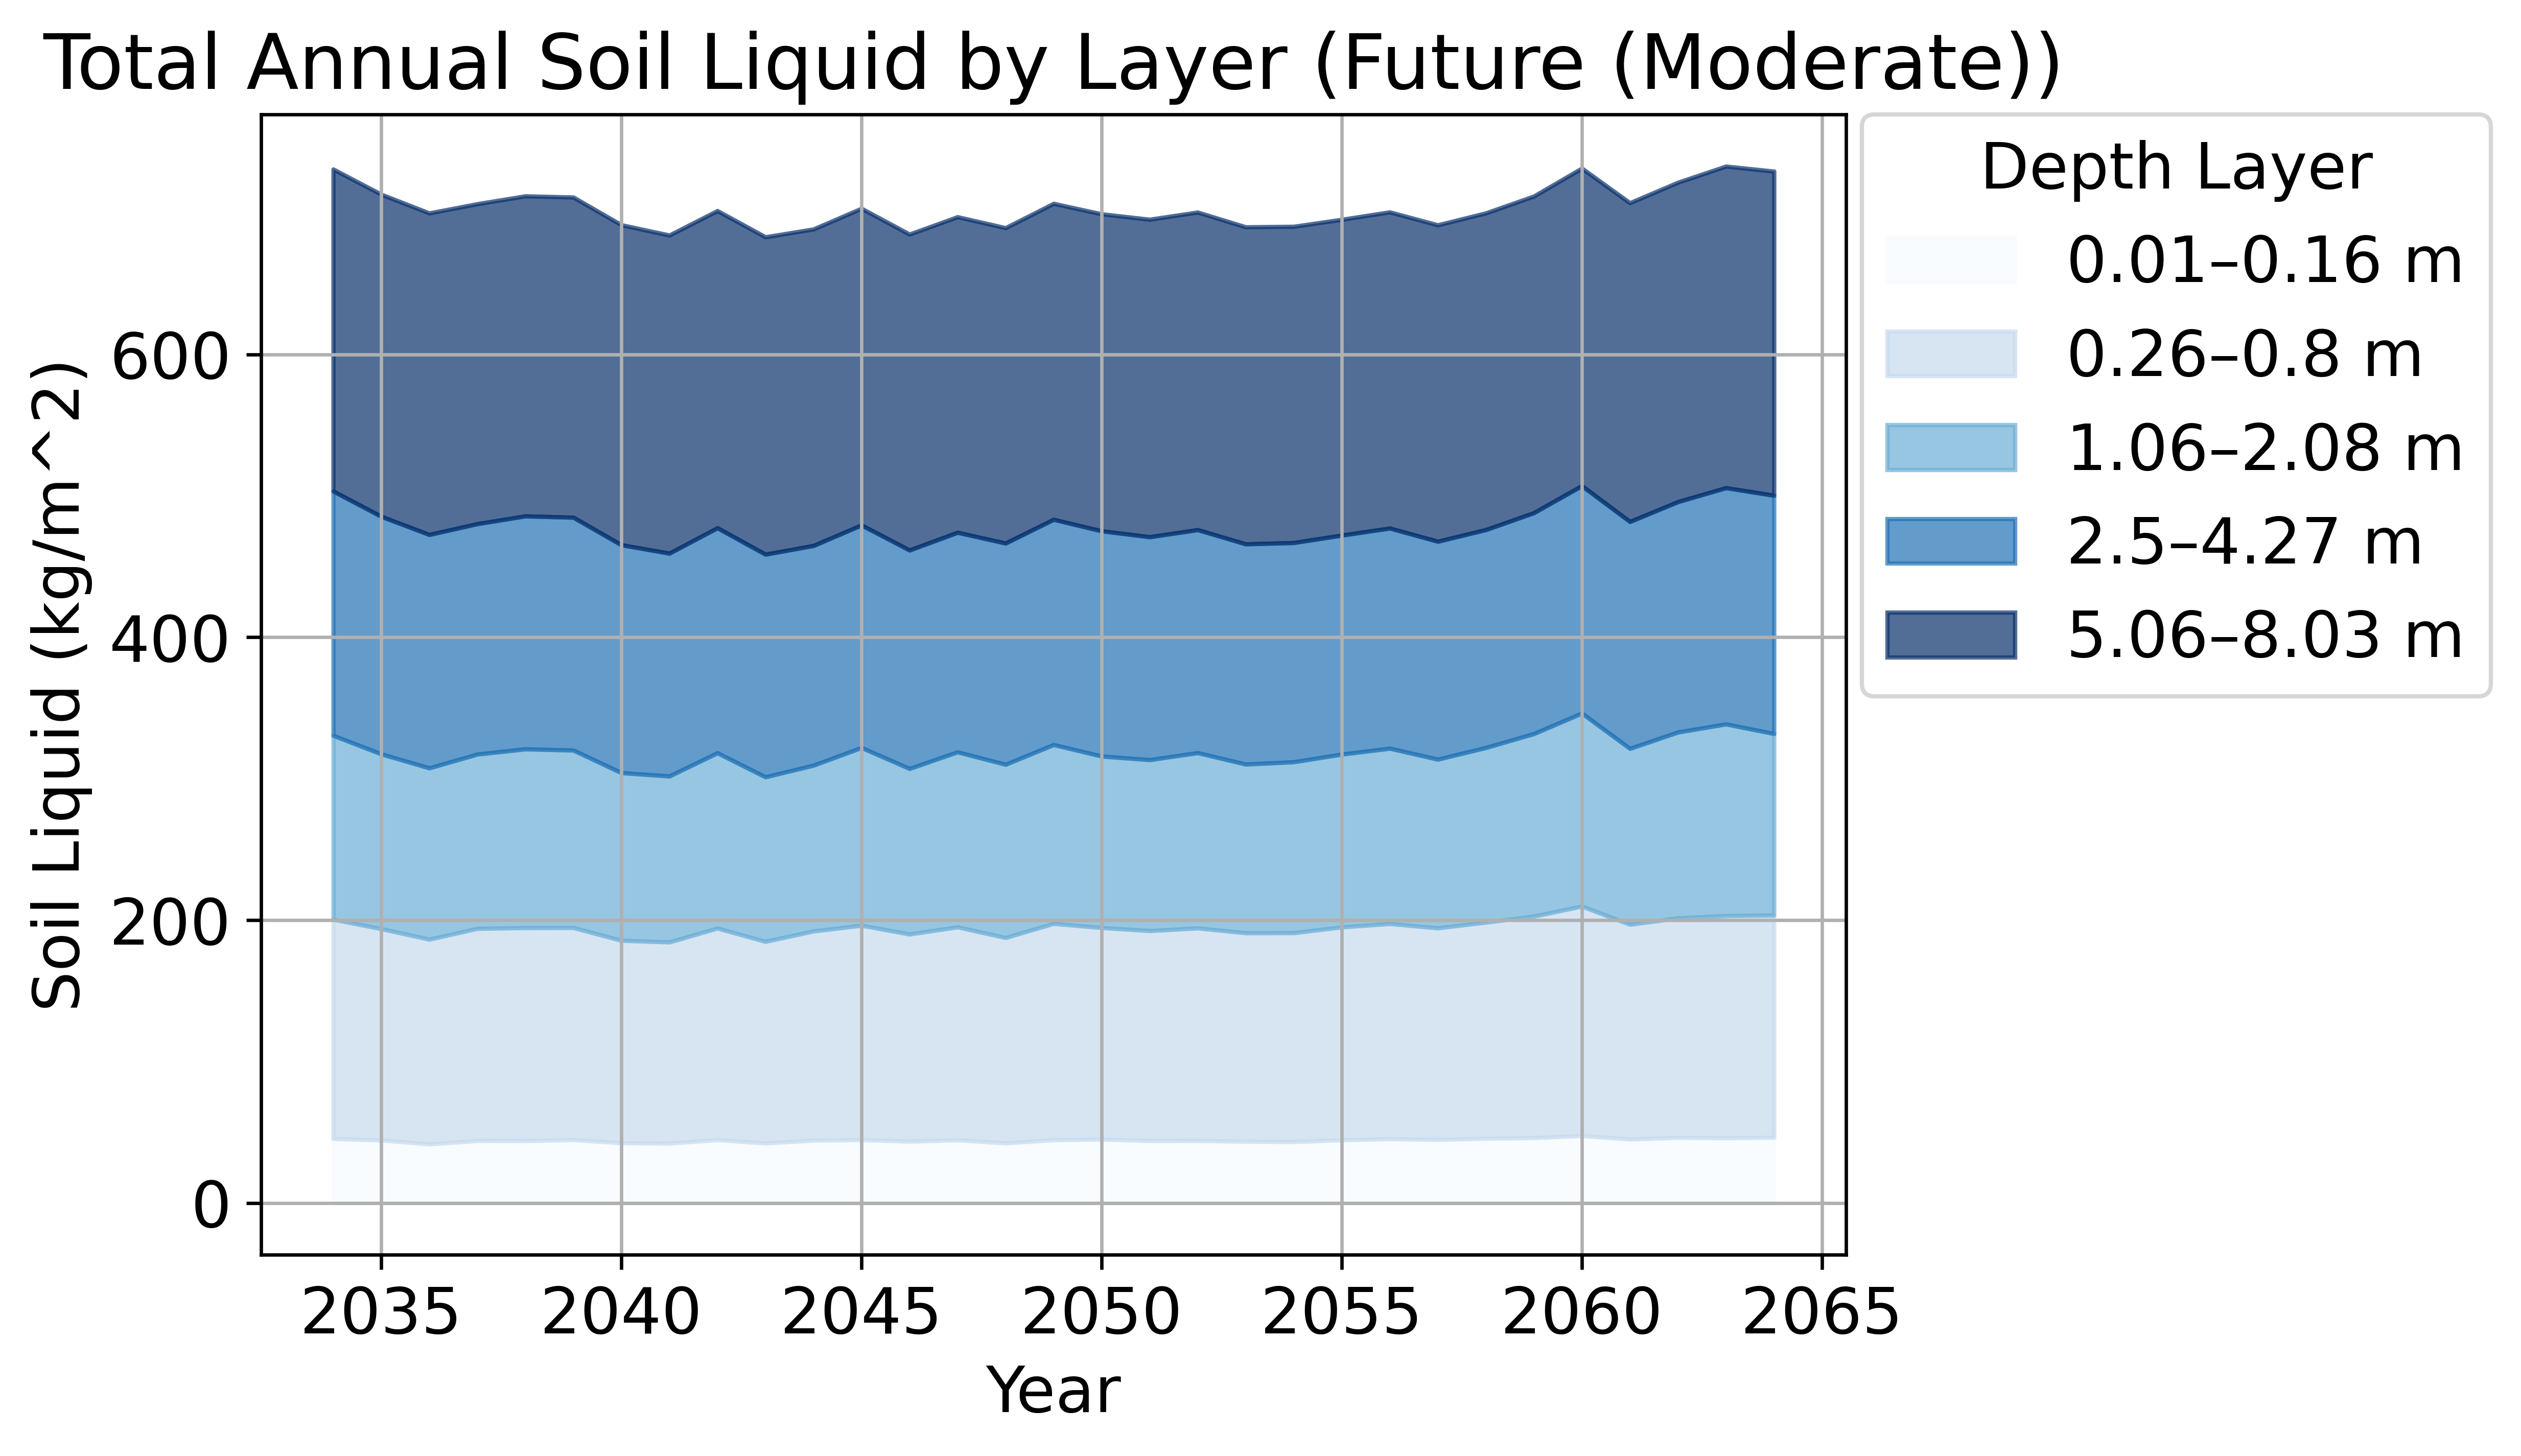

In [7]:
stacker(clean_annual_soil_liquid_M, "Liquid", "Future (Moderate)", "Blues")

In [8]:
### Make averages helper function
def make_averages(data_list):
    """Take a list of tuples (var, name, year_range) in, spit out a dictionary after."""
    df_dictionary = {}
    for thing in data_list:
        n_bins = 5
        layers_per_bin = 20 // n_bins # so 4, but leaving it dynamic in case n changes
        data = thing[0].mean(dim=("lat", "lon")).sel(year=slice(thing[2][0], thing[2][1])).values
        binned_data = np.stack([data[:, i*layers_per_bin : (i+1)*layers_per_bin].sum(axis=1) for i in range(n_bins)], axis=1)
    
        stack = np.cumsum(binned_data, axis=1)
        df = pd.DataFrame(stack, columns=["0.01-0.16", "0.26-0.8", "1.06-2.08", "2.5-4.27", "5.06-8.03"])
        for x in df.keys():
            df_dictionary[(x, thing[1])] = round(df[x].mean().item(), 2)
            
    return df_dictionary

In [9]:
### Data visualization: layers in each scenario over a 30-year period
make_averages([(annual_soil_liquid_P, "Soil Liquid (Historical)", (1990, 2020)),
               (annual_soil_liquid_H, "Soil Liquid (Future (Hot))", (2034, 2064)),
               (annual_soil_liquid_M, "Soil Liquid (Future (Moderate))", (2034, 2064))])

{('0.01-0.16', 'Soil Liquid (Historical)'): 42.35,
 ('0.26-0.8', 'Soil Liquid (Historical)'): 183.52,
 ('1.06-2.08', 'Soil Liquid (Historical)'): 290.87,
 ('2.5-4.27', 'Soil Liquid (Historical)'): 423.64,
 ('5.06-8.03', 'Soil Liquid (Historical)'): 629.35,
 ('0.01-0.16', 'Soil Liquid (Future (Hot))'): 45.32,
 ('0.26-0.8', 'Soil Liquid (Future (Hot))'): 199.46,
 ('1.06-2.08', 'Soil Liquid (Future (Hot))'): 330.16,
 ('2.5-4.27', 'Soil Liquid (Future (Hot))'): 501.61,
 ('5.06-8.03', 'Soil Liquid (Future (Hot))'): 735.36,
 ('0.01-0.16', 'Soil Liquid (Future (Moderate))'): 44.47,
 ('0.26-0.8', 'Soil Liquid (Future (Moderate))'): 194.82,
 ('1.06-2.08', 'Soil Liquid (Future (Moderate))'): 318.65,
 ('2.5-4.27', 'Soil Liquid (Future (Moderate))'): 478.36,
 ('5.06-8.03', 'Soil Liquid (Future (Moderate))'): 703.32}

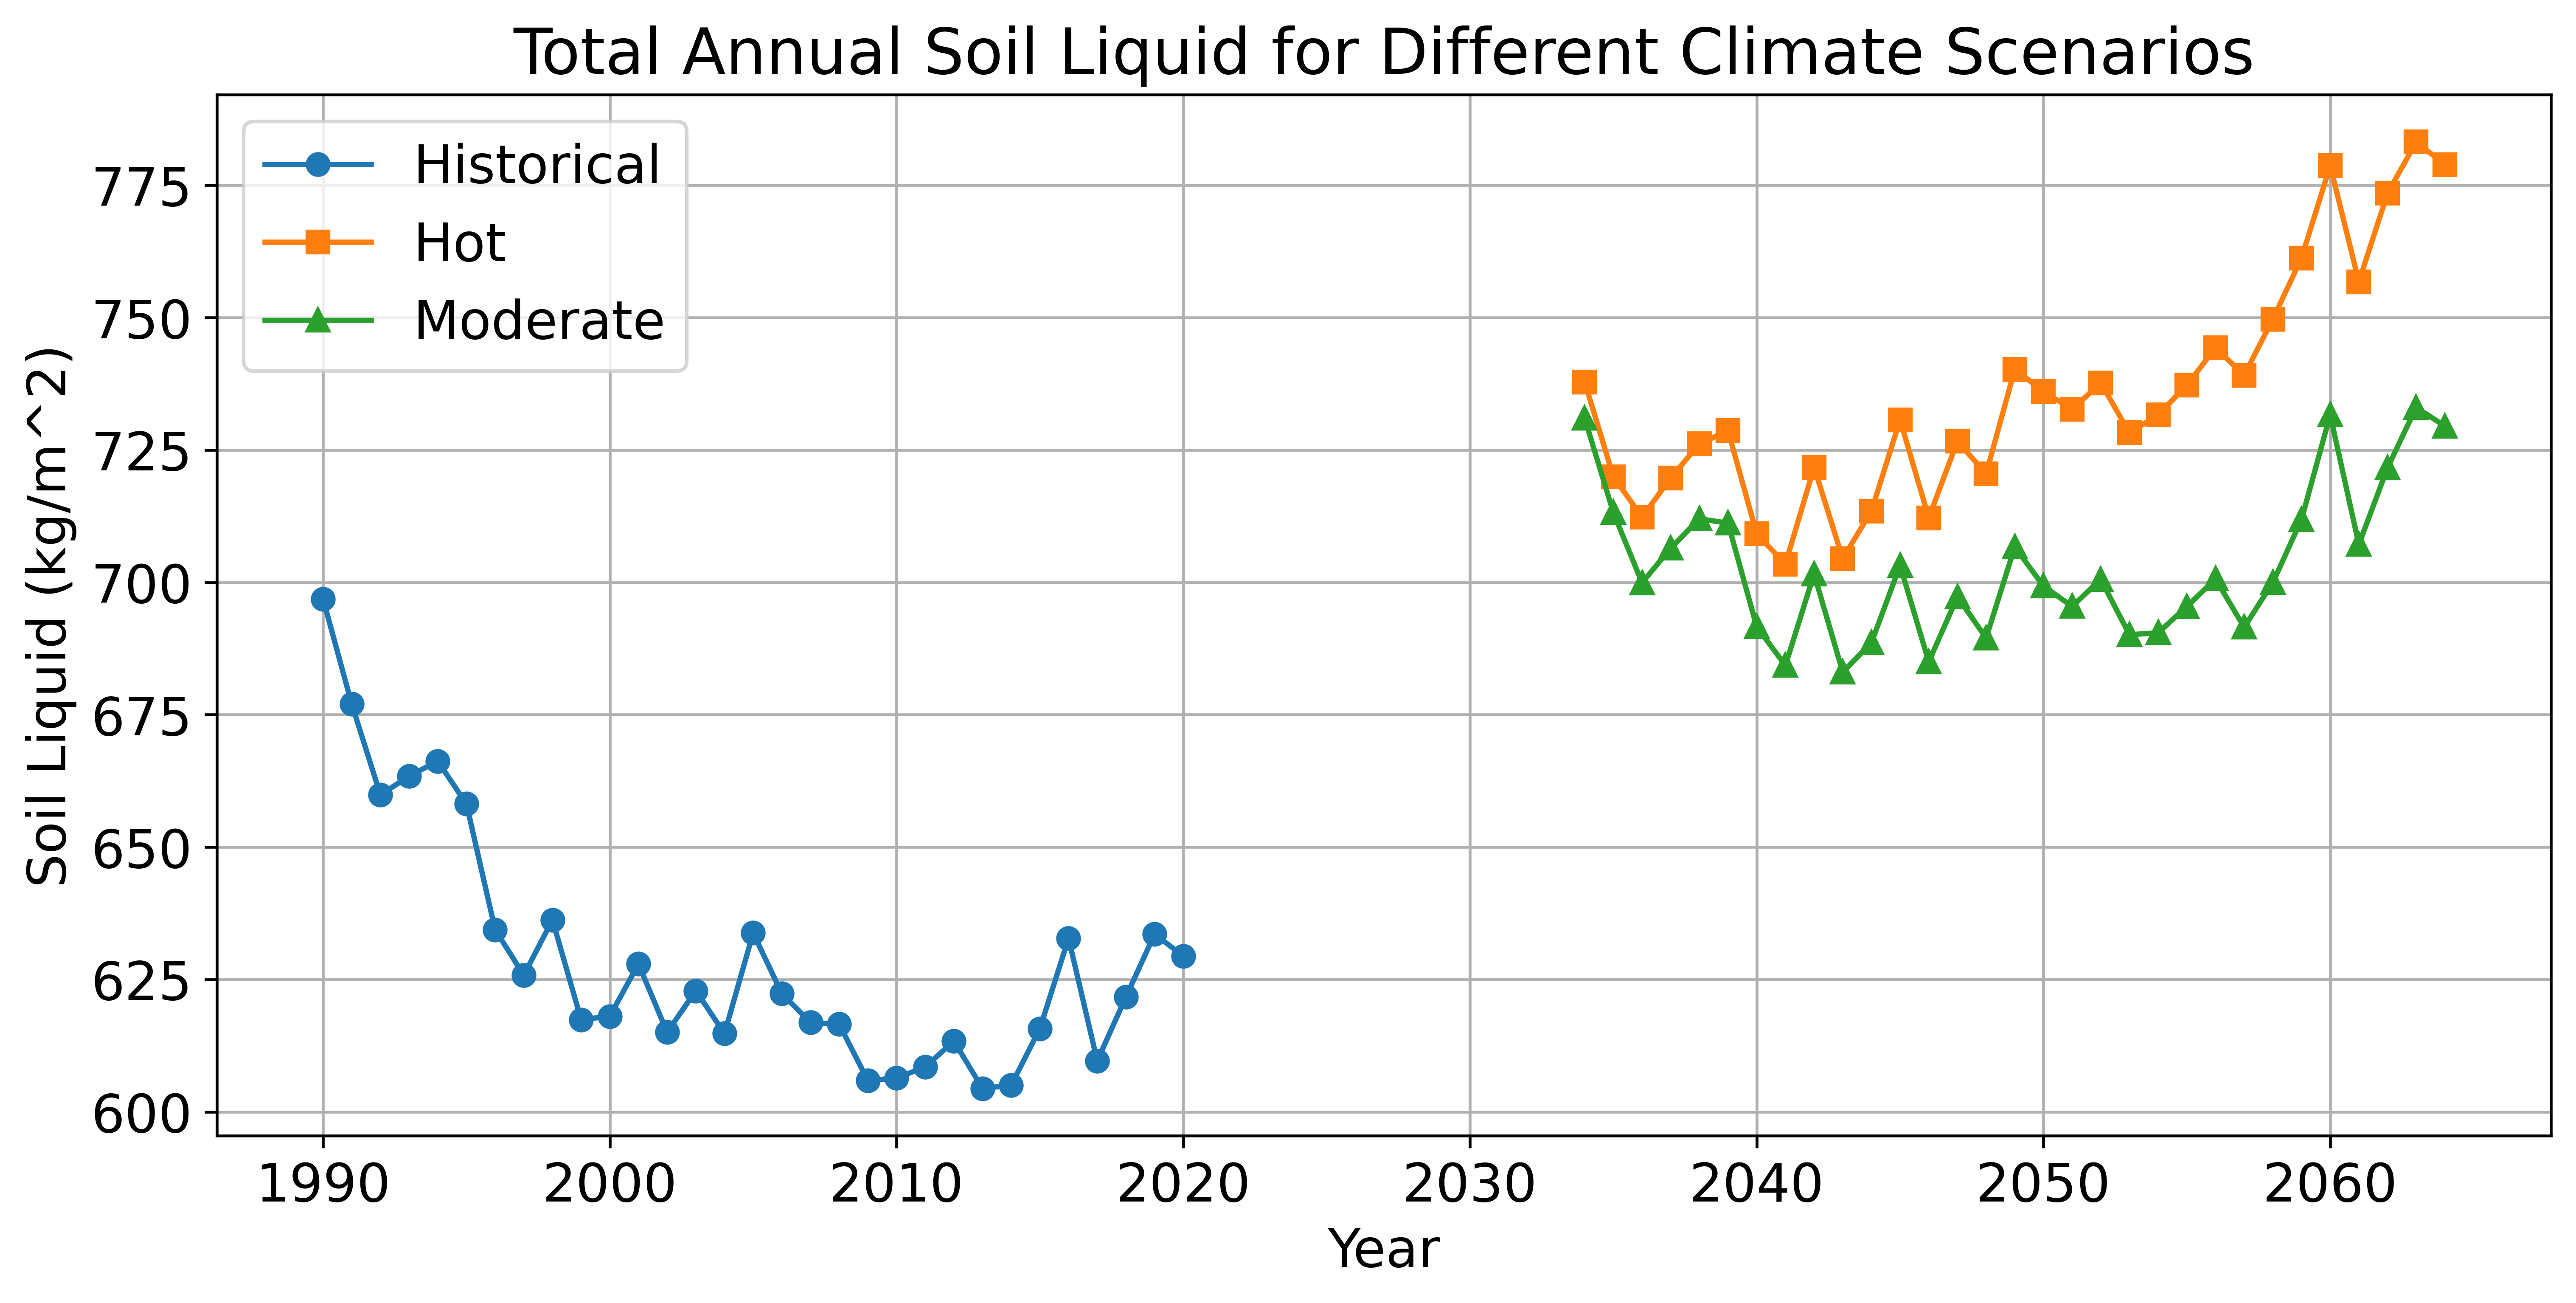

In [10]:
### Data visualization: total annual soil liquid (decomposition of groundwater)
plt.rc('font', size=15)
plt.figure(figsize=(10,5), dpi=600, constrained_layout=True)
plt.plot(annual_soil_liquid_numpy_P.year.values, annual_soil_liquid_numpy_P.values, label="Historical", marker='o', linestyle='-')
plt.plot(annual_soil_liquid_numpy_H.year.values, annual_soil_liquid_numpy_H.values, label="Hot", marker='s', linestyle='-')
plt.plot(annual_soil_liquid_numpy_M.year.values, annual_soil_liquid_numpy_M.values, label="Moderate", marker='^', linestyle='-')
plt.xlabel("Year")
plt.ylabel("Soil Liquid (kg/m^2)")
plt.title("Total Annual Soil Liquid for Different Climate Scenarios")
plt.legend()
plt.grid(True)

## saving this work to disk
os.makedirs("soil_liquid", exist_ok=True)
plt.savefig(f"soil_liquid/plot-total-annual.png")